# Importing libraries

In [46]:
import pandas as pd
from surprise import Dataset
from surprise import Reader
from surprise import KNNBasic
from surprise.model_selection import cross_validate
import matplotlib.pyplot as plt
import numpy as np
from libreco.algorithms import UserCF, ItemCF
from libreco.data import split_by_ratio, DatasetPure
from libreco.evaluation import evaluate
from surprise.model_selection import train_test_split
from surprise import accuracy

# Load the Movielens - 100k dataset

In [6]:
# Step 1: Load the MovieLens-100k Dataset
data = Dataset.load_builtin('ml-100k')
raw_ratings = data.raw_ratings
ratings_df = pd.DataFrame(raw_ratings, columns=['user_id', 'movie_id', 'rating', 'timestamp'])

In [7]:
# Load the movie names
movie_info = pd.read_csv('http://files.grouplens.org/datasets/movielens/ml-100k/u.item', sep='|', encoding='ISO-8859-1', header=None)
movie_info = movie_info[[0, 1]]
movie_info.columns = ['movie_id', 'movie_name']

In [8]:
# Step 2: Merge the Datasets
ratings_df['movie_id'] = ratings_df['movie_id'].astype(int)
movie_info['movie_id'] = movie_info['movie_id'].astype(int)
merged_df = pd.merge(ratings_df, movie_info, on='movie_id')

In [9]:
movie_ratings_df = merged_df[['user_id', 'movie_id', 'movie_name', 'rating', 'timestamp']]
movie_ratings_df.head()

,user_id,movie_id,movie_name,rating,timestamp
0,196,242,Kolya (1996),3.0,881250949
1,63,242,Kolya (1996),3.0,875747190
2,226,242,Kolya (1996),5.0,883888671
3,154,242,Kolya (1996),3.0,879138235
4,306,242,Kolya (1996),5.0,876503793


# User Based Collaborative Filtering with Surprise

In [47]:
userCF_algo = KNNBasic(k=10, sim_options={'name': 'cosine', 'user_based': True})
trainset, testset = train_test_split(data, test_size=0.2)
userCF_algo.fit(trainset)
userCF_predictions = userCF_algo.test(testset)

userCF_rmse = accuracy.rmse(userCF_predictions)
userCF_mae = accuracy.mae(userCF_predictions)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0455
MAE:  0.8235


# Item Based Collaborative Filtering with Surprise

In [48]:
itemCF_algo = KNNBasic(k=10, sim_options={'name': 'cosine', 'user_based': False})
itemCF_algo.fit(trainset)
itemCF_predictions = itemCF_algo.test(testset)
itemCF_rmse = accuracy.rmse(itemCF_predictions)
itemCF_mae = accuracy.mae(itemCF_predictions)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0994
MAE:  0.8682


In [54]:
# Create a DataFrame to hold the results
results = {
    'Model': ['UserCF', 'ItemCF'],
    'RMSE': [userCF_rmse, itemCF_rmse],
    'MAE': [userCF_mae, itemCF_mae]
}
results_df = pd.DataFrame(results)
print(results_df)

    Model      RMSE       MAE
0  UserCF  1.045528  0.823454
1  ItemCF  1.099377  0.868154


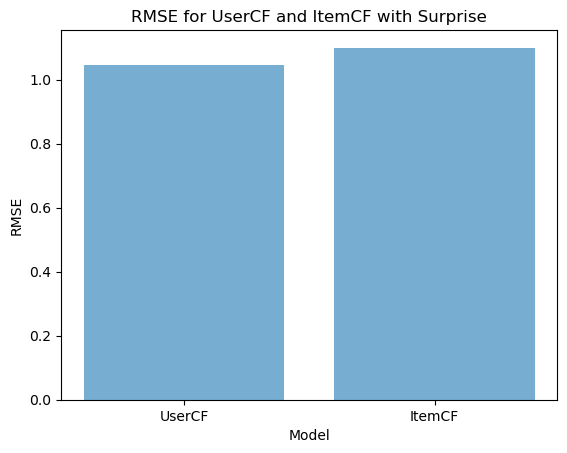

In [56]:
# Plot the results
# Plot RMSE
plt.figure()
plt.bar(results_df['Model'], results_df['RMSE'], alpha=0.6, label='RMSE')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('RMSE for UserCF and ItemCF with Surprise')
plt.show()

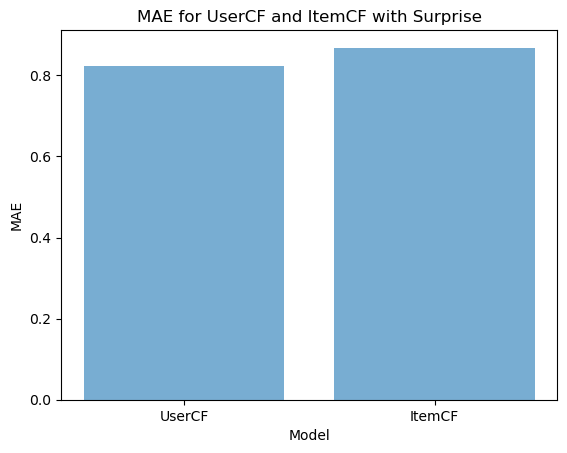

In [57]:
# Plot MAE
plt.figure()
plt.bar(results_df['Model'], results_df['MAE'], alpha=0.6, label='MAE')
plt.xlabel('Model')
plt.ylabel('MAE')
plt.title('MAE for UserCF and ItemCF with Surprise')
plt.show()

# Prepare the data for librecommender

In [58]:
# Prepare data for LibRecommender
user_item_rating_df = pd.DataFrame(user_item_rating, columns=['user', 'item', 'label'])

In [59]:
# Split the data using split_by_ratio
train_data, test_data = split_by_ratio(user_item_rating_df, test_size=0.2)

# Build the train and test sets
train_data, data_info = DatasetPure.build_trainset(train_data)
test_data = DatasetPure.build_testset(test_data)


# User Collaborative Filtering with LibRecommender

In [60]:
data_info

n_users: 943, n_items: 1183, data density: 7.1712 %

In [61]:
# UserCF with LibRecommender
userCF_model = UserCF(task="rating", data_info=data_info, k_sim=10, sim_type="cosine")
userCF_model.fit(train_data,neg_sampling=False)

Training start time: 2024-05-05 15:35:19
Final block size and num: (943, 1)
sim_matrix elapsed: 0.025s
sim_matrix, shape: (943, 943), num_elements: 852150, density: 95.8281 %


top_k: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 943/943 [00:00<00:00, 9182.17it/s]


In [62]:
userCF_metrics = evaluate(userCF_model, test_data,neg_sampling=False, metrics=["rmse", "mae"])
print("UserCF Metrics with LibRecommender:", userCF_metrics)

eval_pointwise:  33%|████████████████████████████████████                                                                        | 1/3 [00:00<00:00,  5.53it/s]

No common interaction or similar neighbor for user 0 and item 244, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 109, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 34, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 196, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 183, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 40, proceed with default prediction


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.12it/s]

UserCF Metrics with LibRecommender: {'rmse': 1.2041178244078892, 'mae': 0.978943618459463}


# Item Collaborative Filtering with LibRecommender

In [63]:
# ItemCF with LibRecommender
itemCF_model = ItemCF(task="rating", data_info= data_info,k_sim=10, sim_type="cosine")
itemCF_model.fit(train_data, neg_sampling=False)
itemCF_metrics = evaluate(itemCF_model, test_data,neg_sampling=False ,metrics=["rmse", "mae"])
print("ItemCF Metrics with LibRecommender:", itemCF_metrics)

Training start time: 2024-05-05 15:35:35
Final block size and num: (1183, 1)
sim_matrix elapsed: 0.027s
sim_matrix, shape: (1183, 1183), num_elements: 994966, density: 111.8883 %


eval_pointwise:   0%|                                                                                                                    | 0/3 [00:00<?, ?it/s]

No common interaction or similar neighbor for user 2 and item 260, proceed with default prediction
No common interaction or similar neighbor for user 2 and item 651, proceed with default prediction
No common interaction or similar neighbor for user 2 and item 331, proceed with default prediction
No common interaction or similar neighbor for user 2 and item 338, proceed with default prediction
No common interaction or similar neighbor for user 2 and item 815, proceed with default prediction
No common interaction or similar neighbor for user 2 and item 819, proceed with default prediction


eval_pointwise: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.90it/s]

ItemCF Metrics with LibRecommender: {'rmse': 1.2902053317157445, 'mae': 1.0063711598315965}


In [41]:
libreco_results = {
    "Model": ["UserCF", "ItemCF"],
    "RMSE": [userCF_metrics["rmse"], itemCF_metrics["rmse"]],
    "MAE": [userCF_metrics["mae"], itemCF_metrics["mae"]],
}

In [42]:
libreco_df = pd.DataFrame(libreco_results)
libreco_df

,Model,RMSE,MAE
0,UserCF,1.204118,0.978944
1,ItemCF,1.290205,1.006371


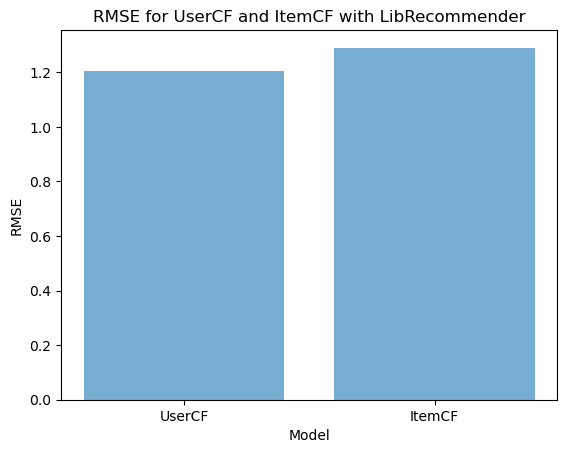

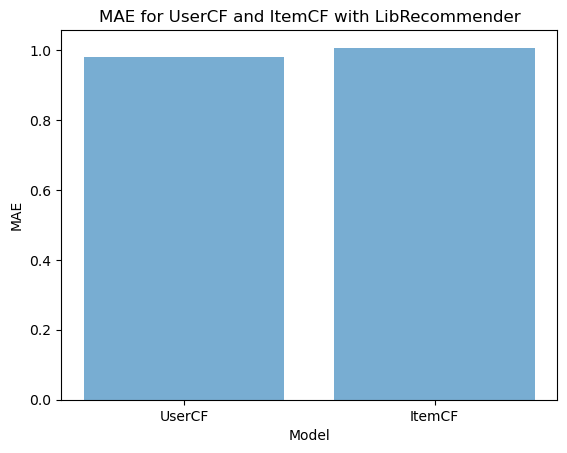

In [64]:
# Plot RMSE
plt.figure()
plt.bar(libreco_df['Model'], libreco_df['RMSE'], alpha=0.6)
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('RMSE for UserCF and ItemCF with LibRecommender')
plt.show()

# Plot MAE
plt.figure()
plt.bar(libreco_df['Model'], libreco_df['MAE'], alpha=0.6)
plt.xlabel('Model')
plt.ylabel('MAE')
plt.title('MAE for UserCF and ItemCF with LibRecommender')
plt.show()

# Now Combined Results

In [65]:
combined_results = {
    'Model': ['Surprise-UserCF', 'Surprise-ItemCF', 'LibRecommender-UserCF', 'LibRecommender-ItemCF'],
    'RMSE': [userCF_rmse, itemCF_rmse, libreco_df.loc[0, 'RMSE'], libreco_df.loc[1, 'RMSE']],
    'MAE': [userCF_mae, itemCF_mae, libreco_df.loc[0, 'MAE'], libreco_df.loc[1, 'MAE']]
}
combined_df = pd.DataFrame(combined_results)
print(combined_df)

                   Model      RMSE       MAE
0        Surprise-UserCF  1.045528  0.823454
1        Surprise-ItemCF  1.099377  0.868154
2  LibRecommender-UserCF  1.204118  0.978944
3  LibRecommender-ItemCF  1.290205  1.006371


# Plot the RMSE Plot

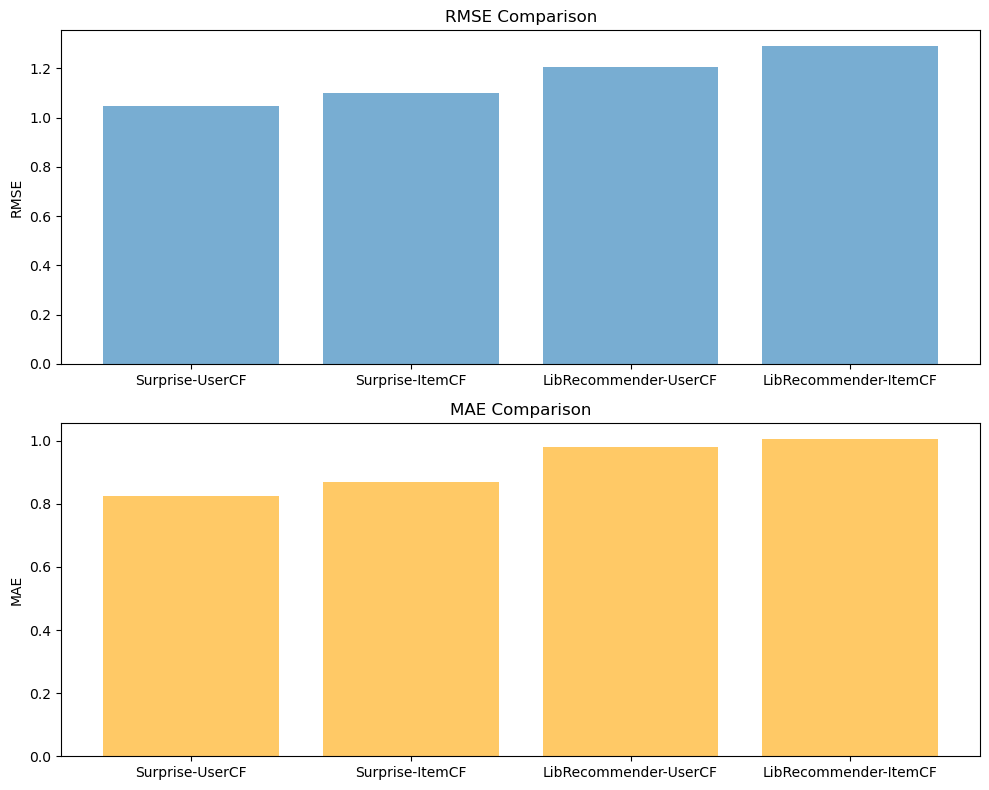

In [67]:
# Plot the RMSE and MAE together for comparison
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Plot RMSE
ax[0].bar(combined_df['Model'], combined_df['RMSE'], alpha=0.6)
ax[0].set_title('RMSE Comparison')
ax[0].set_ylabel('RMSE')
# Plot MAE
ax[1].bar(combined_df['Model'], combined_df['MAE'], alpha=0.6, color='orange')
ax[1].set_title('MAE Comparison')
ax[1].set_ylabel('MAE')

plt.tight_layout()
plt.show()

## RMSE Comparison

Root Mean Square Error (RMSE) is a measure of the differences between predicted values and observed values. It squares the errors before averaging, giving higher weight to larger errors. In this case:

    The RMSE is slightly higher for both LibRecommender methods compared to Surprise methods.
    Surprise-UserCF and Surprise-ItemCF have similar RMSE values, close to 1.0.
    The RMSE for LibRecommender-UserCF and LibRecommender-ItemCF is slightly above 1.1.

## Interpretation:

    Lower RMSE is better.
    The Surprise methods perform slightly better in terms of RMSE compared to the LibRecommender methods.

## MAE Comparison

Mean Absolute Error (MAE) is a measure of the absolute differences between predicted values and observed values. It averages the absolute errors, providing a clear indication of the average magnitude of errors without squaring them. In this case:

    All methods show similar MAE values, around 0.8 to 0.9.
    Surprise-UserCF has the lowest MAE, while the other methods are slightly higher.

## Interpretation:

    Lower MAE is better.
    All methods have comparable performance, but Surprise-UserCF has a slight advantage.

Overall Interpretation

    Performance:
        Surprise generally performs better than LibRecommender, especially in terms of RMSE.
        User-based and item-based collaborative filtering methods have comparable performance within each library.
        The differences between the libraries and methods are not substantial, indicating both are reasonable approaches.
    Recommendation:
        If precision is crucial, Surprise might be a slightly better choice.
        If both RMSE and MAE need to be minimized equally, Surprise-UserCF appears to be the best performing method.